In [4]:
import logging
import os
try:
    from pathlib2 import Path
except ImportError:
    from pathlib import Path

import numpy as np
import torch
import torch.multiprocessing as mp
import parmap

from detect.detector import Detect
from localization_pipeline.denoiser import Denoise

from detect.deduplication import deduplicate_gpu, deduplicate

from scipy.signal import argrelmin

from detect.run import run


In [5]:
geom_path = '/media/cat/julien/spikes_localization_registration/channels_maps/np2_channel_map.npy'
path_nn_detector = '/media/cat/julien/spikes_localization_registration/pretrained_detector/detect_np2.pt'
path_nn_denoiser = '/media/cat/julien/spikes_localization_registration/pretrained_denoiser/denoise.pt'
standardized_path = '/media/cat/julien/nick_drift/different_preprocessings/data_standardized_registered/standardized_unregistered.bin'
standardized_dtype = 'float32'
sampling_rate = 30000
len_recording = 1000
output_directory = 'detection_results_threshold'

geom_array = np.load(geom_path)
apply_nn = False ### If set to false, run voltage threshold instead of NN detector 
spatial_radius = 70
n_sec_chunk = 1
n_processors = 4
n_sec_chunk_gpu_detect = .1
detect_threshold = 6 ## 0.5 if apply NN, 4/5/6 otherwise 
n_filters_detect = [16, 8, 8] 
spike_size_nn = 121 ### In sample steps
n_filters_denoise = [16, 8, 4]
filter_sizes_denoise = [5, 11, 21]
n_batches = len_recording//n_sec_chunk


In [ ]:
sampling_rate = 30000

run(standardized_path, standardized_dtype, output_directory, geom_array, spatial_radius, apply_nn, n_sec_chunk, n_batches, n_processors, n_sec_chunk_gpu_detect, sampling_rate, len_recording,
    detect_threshold, path_nn_detector, n_filters_detect, spike_size_nn, path_nn_denoiser, n_filters_denoise, filter_sizes_denoise, run_chunk_sec='full')

   batch length to (sec):  1  (longer increase speed a bit)
   length of each seg (sec):  0.5


 69%|██████▉   | 1375/2000 [26:13<08:22,  1.24it/s] 

In [ ]:
#### LOCALIZATION

import os
import numpy as np
from tqdm import tqdm
# from residual import RESIDUAL
from localization_pipeline.localizer import LOCALIZER
from localization_pipeline.merge_results import get_merged_arrays


In [ ]:
### Change paths to your data here
bin_file = standardized_path
residual_file = bin_file
dtype_input = 'float32'

fname_spike_train = 'detection_results_threshold/spike_index.npy'
# Sort spike train if not 
spt_array = np.load(fname_spike_train)
spt_array = spt_array[spt_array[:, 0].argsort()]
np.save(fname_spike_train, spt_array)

geom_path = "channels_maps/np2_channel_map.npy"
n_channels = np.load(geom_path).shape[0]

denoiser_weights = path_nn_denoiser
denoiser_min = 42 ## Goes with the weights

n_batches = 1000
len_recording = 1000
sampling_rate = 30000

fname_templates = None

In [ ]:
localizer_obj = LOCALIZER(bin_file, residual_file, dtype_input, fname_spike_train, fname_templates, geom_path, denoiser_weights, denoiser_min)
# localizer_obj.get_offsets()
# localizer_obj.compute_aligned_templates()
localizer_obj.load_denoiser()
output_directory = 'position_results_files'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
for i in tqdm(range(n_batches)):
    localizer_obj.get_estimate(i, threshold = 6, output_directory = 'position_results_files')



In [10]:
from localization_pipeline.merge_results import get_merged_arrays

In [12]:
get_merged_arrays('position_results_files', 'position_results_files_merged', 1000)

100%|██████████| 1000/1000 [00:03<00:00, 257.01it/s]

616581


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import matplotlib.cm as cm

In [28]:
ptp_array = np.load('position_results_files_merged/results_max_ptp_merged.npy')
idx_good = np.where(ptp_array != 0)[0]
x_results = np.load('position_results_files_merged/results_x_merged.npy')[idx_good]
y_results = np.load('position_results_files_merged/results_y_merged.npy')[idx_good]
z_results = np.load('position_results_files_merged/results_z_merged.npy')[idx_good]
times_array = np.load('position_results_files_merged/times_read.npy')[idx_good]


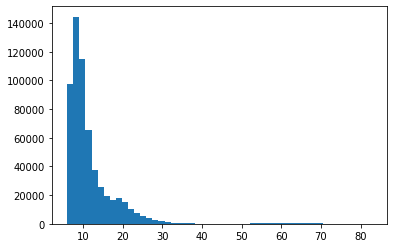

In [21]:
plt.hist(ptp_array[idx_good], bins = 50)
plt.show()

In [24]:
ptp_rescaled = ptp_array[idx_good] - ptp_array[idx_good].min()
ptp_rescaled = ptp_rescaled/ptp_rescaled.max()
ptp_rescaled[ptp_rescaled >= 0.4] = 0.4

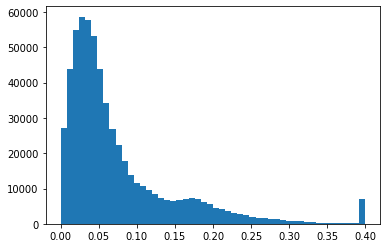

In [25]:
plt.hist(ptp_rescaled, bins = 50)
plt.show()

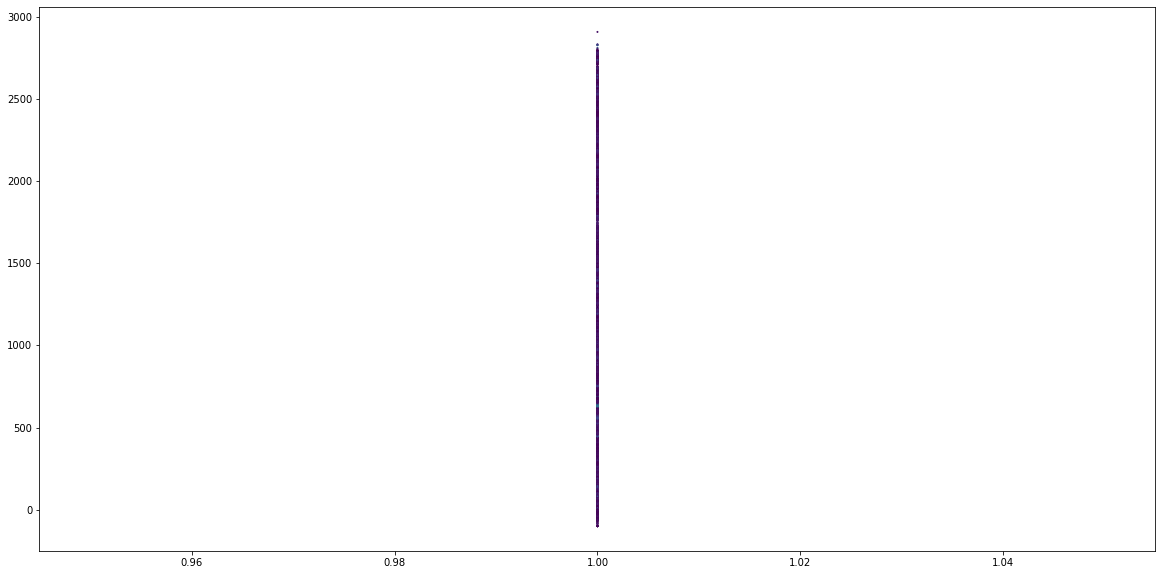

In [26]:
vir = cm.get_cmap('viridis')
plt.figure(figsize = (20, 10))
plt.scatter(times_array, z_results, color = vir(ptp_rescaled), s = 1)
plt.show()

/home/julien/ENTER/envs/yass_run/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


Text(0.5, 1.0, 'LS position \n by max-ptp')

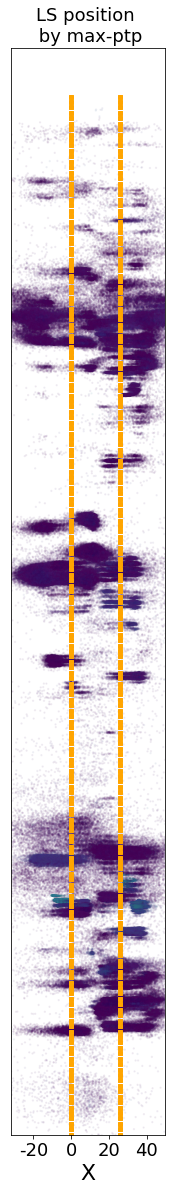

In [31]:
fig = plt.figure(figsize = (26, 20))
spec = gridspec(ncols=8, nrows=1, figure=fig)

vir = cm.get_cmap('viridis')
f_ax = fig.add_subplot(spec[0, 1])

f_ax.set_xlim((-40, 62))
f_ax.scatter(x_results, z_results, s = 2, color = vir(ptp_rescaled), alpha = 0.05) #vir(ptp_scaled_high_units) 0.05
f_ax.scatter(geom_array[:, 0], geom_array[:, 1], c = 'orange', label = "NP channels", marker = 's', s = 10)

f_ax.set_yticks([])
f_ax.set_xticklabels(np.arange(-40, 62, 20), fontsize = 18)
f_ax.set_ylim(0, 3000)

f_ax.set_xlabel("X", fontsize = 22)

f_ax.set_title("LS position \n by max-ptp", fontsize = 18)
plt.show()